In [1]:
#!/usr/bin/env python
# coding: utf-8
import re
import sys
import pandas as pd
import sys
import ast
import matplotlib.pyplot as plt
import os
import time

global _app_name
run_command="/opt/jdk-14/bin/java -Dfile.encoding=UTF-8 -classpath /media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/out/production/iFogSim2:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-examples-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-examples-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/commons-math3-3.5/commons-math3-3.5.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/guava-18.0.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/json-simple-1.1.1.jar org.fog.test.perfeval."

run_command="/usr/lib/jvm/java-17-openjdk-amd64/bin/java -Dfile.encoding=UTF-8 -Dstdout.encoding=UTF-8 -Dstderr.encoding=UTF-8 -classpath /media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/_output/production/iFogSim2:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/cloudsim-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/cloudsim-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/cloudsim-examples-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/cloudsim-examples-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/commons-math3-3.5/commons-math3-3.5.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/guava-18.0.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/json-simple-1.1.1.jar -XX:+ShowCodeDetailsInExceptionMessages org.fog.test.perfeval."


_app_name="TwoDCNSApps"
_app_name="HighResDCNS"
_report_path="Report_Saeedeh/t_pandas.txt"
_save_path="Report_Saeedeh/Pandas"


In [2]:
def run(app_name="TwoDCNSApps", scenario="Router_Proxy", report_path=_report_path): 
    #cmd=f'{run_command}{app_name} {scenario} | tee -a {report_path} >/dev/null'
    cmd=f'{run_command}{app_name} {scenario} 2>&1 >> {report_path}'
    os.system(cmd)

In [3]:
# init
global Scenario,Resolution,app_class,data_frames
Scenario=None
Resolution=None
app_class=None
data_frames=None



# Initialize and maintain other DataFrames as global variables
if 'computation_energy_per_vm_df' not in globals():
    computation_energy_per_vm_df = pd.DataFrame(columns=['app_class','scenario','device', 'app', 'vm', 'energy'])

if 'computation_energy_df' not in globals():
    computation_energy_df = pd.DataFrame(columns=['app_class','scenario','device', 'energy'])

if 'communication_energy_df' not in globals():
    communication_energy_df = pd.DataFrame(columns=['app_class','scenario','device_id', 'device', 'tuple', 'energy'])

#if 'execution_time_df' not in globals():
#    execution_time_df = pd.DataFrame(columns=['app_class','scenario','tuple', 'execution_time'])
if 'loop_delay_df' not in globals():
    loop_delay_df = pd.DataFrame(columns=['app_class','scenario','app','loop_name', 'delay'])
    
if 'loop_count_delay_df' not in globals():
    loop_count_delay_df = pd.DataFrame(columns=['Resolution','loop_count','loop_delay'])
    
if 'simulation_time_df' not in globals():
    simulation_time_df = pd.DataFrame(columns=['app_class','scenario', 'simulation_time'])

In [4]:
# reset: remove report and clear dfs
def _reset():
    #os.system(f'rm {_report_path}')
    computation_energy_per_vm_df = pd.DataFrame(columns=['app_class','scenario','device', 'app', 'vm', 'energy'])
    computation_energy_df = pd.DataFrame(columns=['app_class','scenario','device', 'energy'])
    communication_energy_df = pd.DataFrame(columns=['app_class','scenario','device_id', 'device', 'tuple', 'energy'])
    #execution_time_df = pd.DataFrame(columns=['app_class','scenario','tuple', 'execution_time'])
    loop_delay_df = pd.DataFrame(columns=['app_class','scenario','app','loop_name', 'delay'])
    loop_count_delay_df=pd.DataFrame(columns=['Resolution','loop_count','loop_delay'])
    simulation_time_df = pd.DataFrame(columns=['app_class','scenario', 'simulation_time'])
    time.sleep(3)

In [5]:
# Parsing Functions
# string map to map
def parse_map_string(sample):
    # Use regex to convert the string into a valid JSON format
    formatted_sample = re.sub(r'(\w+)=', r'"\1":', sample)
    formatted_sample = re.sub(r'(\w+)(?==)', r'"\1"', formatted_sample)

    # Parse the formatted string into a dictionary
    parsed_sample = ast.literal_eval(formatted_sample)

    #print(parsed_sample)
    return parsed_sample

# For this format:
def parse_vm_energy(l):
    global computation_energy_per_vm_df
    #l="cloud : Vms Energy Map of device : cloud {dcns_1={user_interface_1=12823.499999997002}, dcns_0={user_interface=13373.078571425585}}"
    pattern = r'^(.*?): Vms Energy Map of device : (.*?) ({.*?})$'  # Adjusted pattern
    # Match the pattern with the line
    match = re.match(pattern, l)
    if match:
        device=match.group(1)
        m=match.group(3)
        apps_vms_energy_map=parse_map_string(m)
        for app in apps_vms_energy_map:
            for vm in apps_vms_energy_map[app]:
                data={'scenario':Scenario, 'device':device,'app':app,'vm':vm, 'energy':apps_vms_energy_map[app][vm]}
                df=pd.DataFrame([data])
                df['app_class']=app_class
                computation_energy_per_vm_df=pd.concat([computation_energy_per_vm_df,df], ignore_index=True)



def parse_device_total_energy(l):
    global computation_energy_df
    #l="cloud : Energy Consumed = 2421940.93607143"
    pattern = r'^(.*?): Energy Consumed = (\d+(\.\d+)?)$'
    match = re.match(pattern, l)
    if match:
        device=match.group(1)
        device_energy=float(match.group(2))
        data={'scenario':Scenario, 'device':device, 'energy':device_energy}
        df=pd.DataFrame([data])
        df['app_class']=app_class
        computation_energy_df=pd.concat([computation_energy_df,df],ignore_index=True)

        
def parse_scenario(l):
    global Scenario
    #l="cloud : Energy Consumed = 2421940.93607143"
    pattern = r'^Scenario (.*?)$'
    match = re.match(pattern, l)
    if match:
        Scenario=match.group(1)
        print(f"\n\n\n*******************************************\nScenario is {Scenario}\n*******************************************")

def parse_resolution(l):
    global Resolution
    #l="cloud : Energy Consumed = 2421940.93607143"
    pattern = r'^Resolution is (\d+(\.\d+)?)$'
    match = re.match(pattern, l)
    if match:
        Resolution=float(match.group(1))
        Resolution = round(Resolution, 1)  # Round to one digit after the point
        print(f"\n\n\n*******************************************\nResolution is {Resolution}\n*******************************************")

        
def parse_app_class(l):
    global app_class
    #l="cloud : Energy Consumed = 2421940.93607143"
    pattern = r'^Starting (.*?)...$'
    match = re.match(pattern, l)
    if match:
        app_class=match.group(1)
        print(f"\n\n\n####################################\napp_class is {app_class}\n###################################")



def parse_tuple_networking_energy(l):
    global communication_energy_df
    #l="6 d-0 Networking Tuples energy Map {dcns_1={MOTION_VIDEO_STREAM_1=134177.01818170713, PTZ_PARAMS_1=3143.6363636335045}, dcns_0={PTZ_PARAMS=3143.636363633739, DETECTED_OBJECT=6943.299999994468}}"
    pattern = r'^(\d+)\s+(\S+)\s+Networking Tuples energy Map\s+({.*})$'
    match = re.match(pattern, l)
    if match:
        device_id=match.group(1)
        device_name=match.group(2)
        m=match.group(3)
        apps_tuples_energy_map=parse_map_string(m)
        for app in apps_tuples_energy_map:
            for tuple_name in apps_tuples_energy_map[app]:
                data={'scenario':Scenario, 'device_id':device_id,'device':device_name,'app':app,'tuple':tuple_name, 'energy':apps_tuples_energy_map[app][tuple_name]}
                df=pd.DataFrame([data])
                df['app_class']=app_class
                communication_energy_df=pd.concat([communication_energy_df,df], ignore_index=True)



# For Tuple execution time
def parse_tuple_execution_time(l):
    global execution_time_df
    #l="MOTION_VIDEO_STREAM --->= 2.9571428571427987"
    pattern = r'^(.*?)\s+--->=\s+(\d+(\.\d+)?)$'
    match = re.match(pattern, l)
    if match:
        tuple_name=match.group(1)
        execution_time=float(match.group(2))
        data={'scenario':Scenario, 'tuple':tuple_name,'execution_time':execution_time}
        df=pd.DataFrame([data])
        df['app_class']=app_class
        display(df)
        execution_time_df=pd.concat([execution_time_df,df],ignore_index=True)



# For loop delay
def parse_loops_delay(l):
    global loop_delay_df
    #l="MOTION_VIDEO_STREAM --->= 2.9571428571427987"
    #pattern = r'^(.*?) ([.*?])\s+--->=\s+(\d+(\.\d+)?)$'
    pattern = r'^(\S+)\s+\[(.*?)\]\s+--->=\s+(\d+\.\d+)$'

    match = re.match(pattern, l)
    if match:
        app_name=match.group(1)
        loop_name=match.group(2)
        loop_name=f'[{loop_name}]'
        loop_delay=float(match.group(3))
        data={'scenario':Scenario, 'app':app_name, 'loop_name':loop_name,'delay':loop_delay}
        df=pd.DataFrame([data])
        df['app_class']=app_class
        display(df)
        loop_delay_df=pd.concat([loop_delay_df,df],ignore_index=True)

        
#


def parse_Loop_Count_Delay(l):
    global loop_count_delay_df
    
    # Define the pattern to extract resolution, loop count, and delay
    pattern = r'Loop count is (\d+) and delay is (\d+(\.\d+)?)  and emit time is (\d+(\.\d+)?) and completion time is (\d+(\.\d+)?)'
    
    # Search for the pattern in the input string 'l'
    match = re.search(pattern, l)
    if match:
        loop_count = int(match.group(1))
        loop_delay = float(match.group(2))
        emit_time = float(match.group(3))
        completion_time = float(match.group(4))
        
        # Create a dictionary to store the data
        data = {'Resolution': float(Resolution), 'loop_count': loop_count, 'loop_delay': loop_delay, 'emit_time': emit_time, 'completion_time': completion_time}
        
        # Create a DataFrame from the dictionary
        df = pd.DataFrame([data])
        
        # Concatenate the new DataFrame with the existing loop_count_delay_df
        loop_count_delay_df = pd.concat([loop_count_delay_df, df], ignore_index=True)



# For total simulation time
def parse_simulation_time(l):
    #l="EXECUTION TIME = 370"
    pattern = r'^EXECUTION TIME = (\d+(\.\d+)?)$'
    global simulation_time_df
    match = re.match(pattern, l)
    if match:
        exec_time=match.group(1)
        data={'scenario':Scenario, 'simulation_time':exec_time}
        df=pd.DataFrame([data])
        df['app_class']=app_class
        simulation_time_df=pd.concat([simulation_time_df,df],ignore_index=True)

In [6]:
# Parse
def parse(report_path=_report_path):
    with open(report_path, 'r') as file:
        for l in file:
            parse_app_class(l)
            parse_scenario(l)
            parse_vm_energy(l)
            parse_device_total_energy(l)
            parse_tuple_networking_energy(l)
            #parse_tuple_execution_time(l)
            parse_loops_delay(l)
            parse_Loop_Count_Delay(l)
            parse_resolution(l)
            parse_simulation_time(l)
        

In [7]:
def save(save_path=_save_path):
    global data_frames
    # Combine all DataFrames
    data_frames = {
        'Computation Energy VMs': computation_energy_per_vm_df,
        'Computation Energy Devices': computation_energy_df,
        'Communication Energy': communication_energy_df,
        #'Execution Time': execution_time_df,
        'Loop Delay': loop_delay_df,
        'loop Count Delay': loop_count_delay_df,
        'Simulation Time': simulation_time_df
    }
    # Save each DataFrame to a separate CSV file
    for name, df in data_frames.items():
        df.to_csv(f"{save_path}/{name}.csv", index=False)

In [8]:
def sort_scenarios():
    global data_frames
    # Combine all DataFrames
    computation_energy_per_vm_df['energy']=computation_energy_per_vm_df['energy']/1000
    #computation_energy_df['energy']=computation_energy_df['energy']/1000
    communication_energy_df['energy']=communication_energy_df['energy']/1000
    data_frames = {
        'Computation Energy VMs': computation_energy_per_vm_df,
        'Computation Energy Devices': computation_energy_df,
        'Communication Energy': communication_energy_df,
        #'Execution Time': execution_time_df,
        'Loop Delay': loop_delay_df,
        'Simulation Time': simulation_time_df
    }
    for key in data_frames:
        df = data_frames[key]
        # Create a categorical Series for the 'scenario' column
        df['scenario'] = pd.Categorical(df['scenario'], categories=scenarios_list, ordered=True)
        
        # Sort the DataFrame based on the specified order
        df_sorted = df.sort_values(by=['scenario'])
        # Update the DataFrame in the dictionary
        data_frames[key] = df_sorted

In [9]:
def load(save_path=_save_path):
    global data_frames
    global computation_energy_per_vm_df,computation_energy_df,communication_energy_df,execution_time_df,simulation_time_df
    # Combine all DataFrames
    '''data_frames = {
        'Computation Energy VMs': computation_energy_per_vm_df,
        'Computation Energy Devices': computation_energy_df,
        'Communication Energy': communication_energy_df,
        'Execution Time': execution_time_df,
        'Simulation Time': simulation_time_df
    }'''
    # Save each DataFrame to a separate CSV file
    for name, df in data_frames.items():
        df.read_csv(f"{save_path}/{name}.csv", index=False)
    computation_energy_per_vm_df=data_frames['Computation Energy VMs']
    computation_energy_df=data_frames['Computation Energy Devices']
    communication_energy_df=data_frames['Communication Energy']
    #execution_time_df=data_frames['Execution Time']
    loop_delay_df=data_frames['Loop Delay']
    simulation_time_df=data_frames['Simulation Time']

In [10]:
_load=False
if _load:
    _reset()
    load()

In [11]:

run1=True
scenarios_list=[ 'Router_Only','Router_Proxy','Router_Cloud','Proxy_Only','Proxy_Cloud','Cloud_Only','ModuleBased_Router_Proxy']
if run1:
    _reset()
    for scenario in scenarios_list:
        run("TwoDCNSApps", scenario)
        run("HighResTwoDCNSApp", scenario)
        run("LowResTwoDCNSApp", scenario)


In [12]:
# Experiment for loop delay and count for each resolution
run2=False
if run2:
    _reset()
    for i in range(1,51):
        res=i*0.1
        run("HighResDCNS",res)

In [13]:
# Parse the results
_reset()
parse()
sort_scenarios()
save()





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is Router_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_0,"[motion_detector, object_detector, object_trac...",5.057143,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",3.15,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",5.357143,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",3.11,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is Router_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_0,"[motion_detector, object_detector, object_trac...",7.914286,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",3.15,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",8.614286,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",3.11,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is Router_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_0,"[motion_detector, object_detector, object_trac...",3.628571,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",3.15,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",3.728571,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",3.11,LowResTwoDCNSApps





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is Router_Proxy
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_0,"[motion_detector, object_detector, object_trac...",3.828571,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_0,"[object_tracker, PTZ_CONTROL]",3.11,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_1,"[motion_detector_1, object_detector_1, object_...",6.061429,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is Router_Proxy
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_0,"[motion_detector, object_detector, object_trac...",5.457143,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_0,"[object_tracker, PTZ_CONTROL]",3.11,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_1,"[motion_detector_1, object_detector_1, object_...",7.923571,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is Router_Proxy
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_0,"[motion_detector, object_detector, object_trac...",3.014286,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_0,"[object_tracker, PTZ_CONTROL]",3.11,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_1,"[motion_detector_1, object_detector_1, object_...",5.155714,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,LowResTwoDCNSApps





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is Router_Cloud
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_0,"[motion_detector, object_detector, object_trac...",3.828571,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_0,"[object_tracker, PTZ_CONTROL]",3.11,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_1,"[motion_detector_1, object_detector_1, object_...",104.755,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.112,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is Router_Cloud
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_0,"[motion_detector, object_detector, object_trac...",5.457143,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_0,"[object_tracker, PTZ_CONTROL]",3.11,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_1,"[motion_detector_1, object_detector_1, object_...",105.285,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.112,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is Router_Cloud
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_0,"[motion_detector, object_detector, object_trac...",3.014286,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_0,"[object_tracker, PTZ_CONTROL]",3.11,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_1,"[motion_detector_1, object_detector_1, object_...",104.515,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.112,LowResTwoDCNSApps





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is Proxy_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_0,"[motion_detector, object_detector, object_trac...",7.102338,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",5.151,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",7.557143,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is Proxy_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_0,"[motion_detector, object_detector, object_trac...",9.940101,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",5.151,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",10.917754,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is Proxy_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_0,"[motion_detector, object_detector, object_trac...",5.651429,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",5.151,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",5.926429,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,LowResTwoDCNSApps





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is Proxy_Cloud
*******************************************


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_0,"[motion_detector, object_detector, object_trac...",5.861429,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_0,"[object_tracker, PTZ_CONTROL]",5.111,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_1,"[motion_detector_1, object_detector_1, object_...",104.755,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.151,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is Proxy_Cloud
*******************************************


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_0,"[motion_detector, object_detector, object_trac...",7.523571,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_0,"[object_tracker, PTZ_CONTROL]",5.111,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_1,"[motion_detector_1, object_detector_1, object_...",105.285,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.151,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is Proxy_Cloud
*******************************************


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_0,"[motion_detector, object_detector, object_trac...",5.055714,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_0,"[object_tracker, PTZ_CONTROL]",5.111,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_1,"[motion_detector_1, object_detector_1, object_...",104.515,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.151,LowResTwoDCNSApps





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is Cloud_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_0,"[motion_detector, object_detector, object_trac...",104.555,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",105.152,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",104.805,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.112,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is Cloud_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_0,"[motion_detector, object_detector, object_trac...",104.885,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",105.152,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",105.3,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.112,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is Cloud_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_0,"[motion_detector, object_detector, object_trac...",104.4,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",105.152,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",104.5,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.112,LowResTwoDCNSApps





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is ModuleBased_Router_Proxy
*******************************************


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_0,"[motion_detector, object_detector, object_trac...",7.060632,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_0,"[object_tracker, PTZ_CONTROL]",5.151,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_1,"[motion_detector_1, object_detector_1, object_...",7.260632,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is ModuleBased_Router_Proxy
*******************************************


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_0,"[motion_detector, object_detector, object_trac...",9.918765,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_0,"[object_tracker, PTZ_CONTROL]",5.151,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_1,"[motion_detector_1, object_detector_1, object_...",10.318765,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is ModuleBased_Router_Proxy
*******************************************


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_0,"[motion_detector, object_detector, object_trac...",5.631561,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_0,"[object_tracker, PTZ_CONTROL]",5.151,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_1,"[motion_detector_1, object_detector_1, object_...",5.731561,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,LowResTwoDCNSApps


In [14]:
# rearange 
t=computation_energy_per_vm_df
t=t.pivot_table(index=['scenario','app_class','app'],columns=['vm'],values='energy',aggfunc='sum')
#t.reset_index(inplace=True)
#t=t.reindex(columns=scenarios_list)
t=t.transpose()
display(t)
t.to_csv("jj.csv")




scenario                 Router_Only                                           
app_class         HighResTwoDCNSApps            LowResTwoDCNSApps              
app                           dcns_0     dcns_1            dcns_0     dcns_1   
vm                                                                             
motion_detector            67.923280   0.000000         16.980820   0.000000  \
motion_detector_1           0.000000  67.923280          0.000000  16.980820   
object_detector            29.484490   0.000000          7.437059   0.000000   
object_detector_1           0.000000  29.441554          0.000000   7.437059   
object_tracker              7.360389   0.000000          7.437059   0.000000   
object_tracker_1            0.000000   7.360389          0.000000   7.437059   
user_interface              2.966400   0.000000          2.966400   0.000000   
user_interface_1            0.000000   2.966400          0.000000   2.966400   

scenario                                       Router_Proxy              
app_class         TwoDCNSApps            HighResTwoDCNSApps              
app                    dcns_0     dcns_1             dcns_0     dcns_1   
vm                                                                       
motion_detector     33.961640   0.000000          67.923280   0.000000  \
motion_detector_1    0.000000  33.961640           0.000000  67.923280   
object_detector     14.874119   0.000000          29.441554   0.000000   
object_detector_1    0.000000  14.874119           0.000000  29.718182   
object_tracker       7.437059   0.000000           7.360389   0.000000   
object_tracker_1     0.000000   7.437059           0.000000   7.360389   
user_interface       2.966400   0.000000           2.966400   0.000000   
user_interface_1     0.000000   2.966400           0.000000   2.966400   

scenario                                        ...        Cloud_Only   
app_class         LowResTwoDCNSApps             ... LowResTwoDCNSApps   
app                          dcns_0     dcns_1  ...            dcns_0   
vm                                              ...                     
motion_detector           16.980820   0.000000  ...          16.98082  \
motion_detector_1          0.000000  16.980820  ...           0.00000   
object_detector            7.437059   0.000000  ...          15.16160   
object_detector_1          0.000000   8.024587  ...           0.00000   
object_tracker             7.437059   0.000000  ...          14.86496   
object_tracker_1           0.000000   7.437059  ...           0.00000   
user_interface             2.966400   0.000000  ...           0.29664   
user_interface_1           0.000000   2.966400  ...           0.00000   

scenario                                           ModuleBased_Router_Proxy   
app_class                   TwoDCNSApps                  HighResTwoDCNSApps   
app                  dcns_1      dcns_0     dcns_1                   dcns_0   
vm                                                                            
motion_detector     0.00000   33.961640   0.000000                67.923280  \
motion_detector_1  16.98082    0.000000  33.961640                 0.000000   
object_detector     0.00000   21.226240   0.000000                29.484490   
object_detector_1   9.09696    0.000000  21.127356                 0.000000   
object_tracker      0.00000   16.578876   0.000000                 7.798608   
object_tracker_1   19.74304    0.000000  36.420800                 0.000000   
user_interface      0.00000    0.197756   0.000000                 2.966400   
user_interface_1    1.48320    0.000000   1.483200                 0.000000   

scenario                                                                
app_class                    LowResTwoDCNSApps            TwoDCNSApps   
app                   dcns_1            dcns_0     dcns_1      dcns_0   
vm                                                                      
motion_detector     0.000000    

In [15]:
computation_energy_per_vm_df.query("app_class=='HighResTwoDCNSApps' and app=='dcns_1' and vm=='object_detector_1'")

,app_class,scenario,device,app,vm,energy
17,HighResTwoDCNSApps,Router_Only,d-0,dcns_1,object_detector_1,29.441554
59,HighResTwoDCNSApps,Router_Proxy,proxy-server,dcns_1,object_detector_1,29.718182
100,HighResTwoDCNSApps,Router_Cloud,cloud,dcns_1,object_detector_1,34.492640
143,HighResTwoDCNSApps,Proxy_Only,proxy-server,dcns_1,object_detector_1,29.751733
184,HighResTwoDCNSApps,Proxy_Cloud,cloud,dcns_1,object_detector_1,34.492640
226,HighResTwoDCNSApps,Cloud_Only,cloud,dcns_1,object_detector_1,37.294231
270,HighResTwoDCNSApps,ModuleBased_Router_Proxy,d-0,dcns_1,object_detector_1,29.441554


vm                                           motion_detector   
scenario                 app_class   app                       
Router_Only              TwoDCNSApps dcns_0         33.96164  \
                                     dcns_1          0.00000   
Router_Proxy             TwoDCNSApps dcns_0         33.96164   
                                     dcns_1          0.00000   
Router_Cloud             TwoDCNSApps dcns_0         33.96164   
                                     dcns_1          0.00000   
Proxy_Only               TwoDCNSApps dcns_0         33.96164   
                                     dcns_1          0.00000   
Proxy_Cloud              TwoDCNSApps dcns_0         33.96164   
                                     dcns_1          0.00000   
Cloud_Only               TwoDCNSApps dcns_0         33.96164   
                                     dcns_1          0.00000   
ModuleBased_Router_Proxy TwoDCNSApps dcns_0         33.96164   
                                     dcns_1          0.00000   

vm                                           motion_detector_1   
scenario                 app_class   app                         
Router_Only              TwoDCNSApps dcns_0            0.00000  \
                                     dcns_1           33.96164   
Router_Proxy             TwoDCNSApps dcns_0            0.00000   
                                     dcns_1           33.96164   
Router_Cloud             TwoDCNSApps dcns_0            0.00000   
                                     dcns_1           33.96164   
Proxy_Only               TwoDCNSApps dcns_0            0.00000   
                                     dcns_1           33.96164   
Proxy_Cloud              TwoDCNSApps dcns_0            0.00000   
                                     dcns_1           33.96164   
Cloud_Only               TwoDCNSApps dcns_0            0.00000   
                                     dcns_1           33.96164   
ModuleBased_Router_Proxy TwoDCNSApps dcns_0            0.00000   
                                     dcns_1           33.96164   

vm                                           object_detector   
scenario                 app_class   app                       
Router_Only              TwoDCNSApps dcns_0        14.874119  \
                                     dcns_1         0.000000   
Router_Proxy             TwoDCNSApps dcns_0        14.874119   
                                     dcns_1         0.000000   
Router_Cloud             TwoDCNSApps dcns_0        14.874119   
                                     dcns_1         0.000000   
Proxy_Only               TwoDCNSApps dcns_0        15.174116   
                                     dcns_1         0.000000   
Proxy_Cloud              TwoDCNSApps dcns_0        15.528580   
                                     dcns_1         0.000000   
Cloud_Only               TwoDCNSApps dcns_0        21.226240   
                                     dcns_1         0.000000   
ModuleBased_Router_Proxy TwoDCNSApps dcns_0        14.874119   
                                     dcns_1         0.000000   

vm                                           object_detector_1   
scenario                 app_class   app                         
Router_Only              TwoDCNSApps dcns_0           0.000000  \
                                     dcns_1          14.874119   
Router_Proxy             TwoDCNSApps dcns_0           0.000000   
                                     dcns_1          15.528580   
Router_Cloud             TwoDCNSApps dcns_0           0.000000   
                                     dcns_1          21.226240   
Proxy_Only               TwoDCNSApps dcns_0           0.000000   
                                     dcns_1          15.260478   
Proxy_Cloud              TwoDCNSApps dcns_0           0.000000   
                                     dcns_1          21.226240   
Cloud_Only               TwoDCNSApps dcns_0           0.000000   
                                   

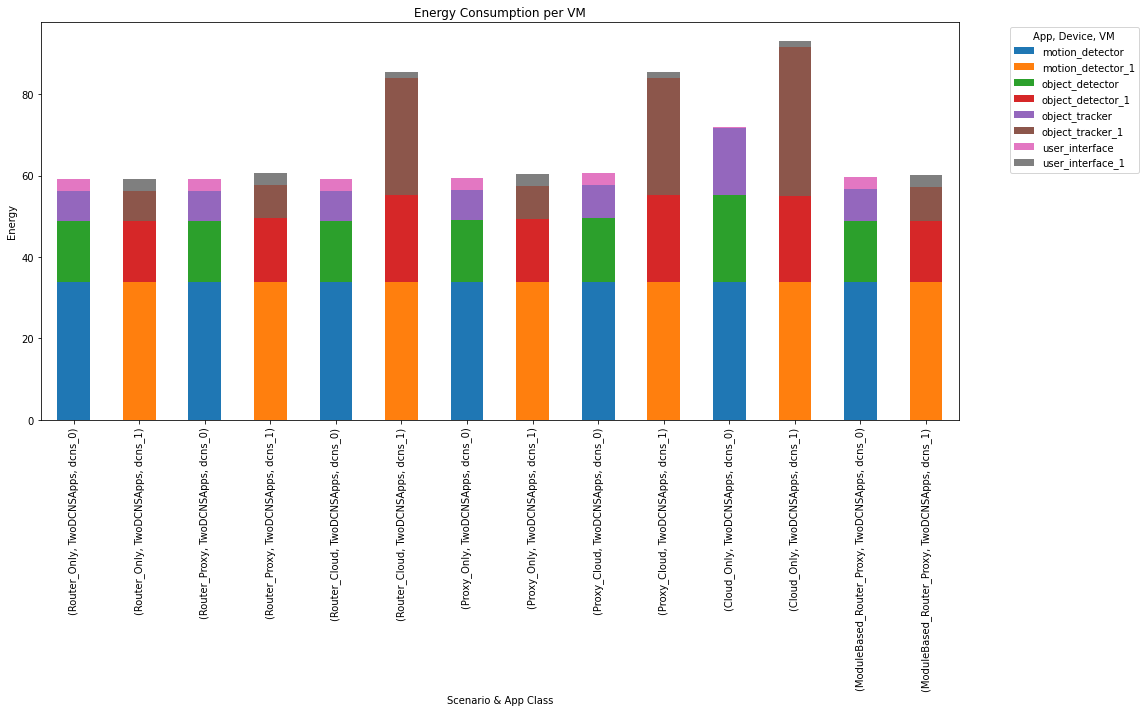

In [16]:
#VM computation Energy for twodcns(figure edge2024)
t=computation_energy_per_vm_df
t=t.query("app_class=='TwoDCNSApps'")
#t['energy']=t['energy']/1000

#print(t.query("scenario == 'Router_Only'"))

pivot_df = t.pivot_table(index=['scenario','app_class','app'],columns=['vm'],values='energy',aggfunc='sum')
display(pivot_df)
# Plotting
ax=pivot_df.plot(kind='bar', stacked=True, figsize=(16, 10))
# Customize appearance
ax.set_title("Energy Consumption per VM")
ax.set_xlabel("Scenario & App Class")
ax.set_ylabel("Energy")
ax.legend(title='App, Device, VM', bbox_to_anchor=(1.05, 1), loc='upper left')


hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
hatch_idx = 0
for patch in ax.patches:
    if hatch_idx >= len(hatch_patterns):
        hatch_idx = 0
    if patch.get_label().startswith('app_1'):
        patch.set_hatch(hatch_patterns[hatch_idx])
        hatch_idx += 1


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


       app_class                  scenario device_id        device   
0    TwoDCNSApps               Router_Only         5  proxy-server  \
1    TwoDCNSApps               Router_Only         5  proxy-server   
2    TwoDCNSApps               Router_Only         6           d-0   
3    TwoDCNSApps               Router_Only         6           d-0   
4    TwoDCNSApps               Router_Only         6           d-0   
..           ...                       ...       ...           ...   
301  TwoDCNSApps  ModuleBased_Router_Proxy         8         m-0-1   
302  TwoDCNSApps  ModuleBased_Router_Proxy         9         m-0-2   
303  TwoDCNSApps  ModuleBased_Router_Proxy         9         m-0-2   
304  TwoDCNSApps  ModuleBased_Router_Proxy        10         m-0-3   
305  TwoDCNSApps  ModuleBased_Router_Proxy        10         m-0-3   

                     tuple    energy     app  
0        DETECTED_OBJECT_1  1.642550  dcns_1  
1          DETECTED_OBJECT  1.642550  dcns_0  
2             PTZ_

tuple                                        MOTION_VIDEO_STREAM   
scenario                 app_class   app                           
Router_Only              TwoDCNSApps dcns_0            11.338297  \
                                     dcns_1             0.000000   
Router_Proxy             TwoDCNSApps dcns_0            11.338297   
                                     dcns_1             0.000000   
Router_Cloud             TwoDCNSApps dcns_0            11.338297   
                                     dcns_1             0.000000   
Proxy_Only               TwoDCNSApps dcns_0            46.325315   
                                     dcns_1             0.000000   
Proxy_Cloud              TwoDCNSApps dcns_0            46.325315   
                                     dcns_1             0.000000   
Cloud_Only               TwoDCNSApps dcns_0            79.867915   
                                     dcns_1             0.000000   
ModuleBased_Router_Proxy TwoDCNSApps dcns_0            11.338297   
                                     dcns_1             0.000000   

tuple                                        MOTION_VIDEO_STREAM_1   
scenario                 app_class   app                             
Router_Only              TwoDCNSApps dcns_0               0.000000  \
                                     dcns_1              11.338297   
Router_Proxy             TwoDCNSApps dcns_0               0.000000   
                                     dcns_1              46.325315   
Router_Cloud             TwoDCNSApps dcns_0               0.000000   
                                     dcns_1              79.867915   
Proxy_Only               TwoDCNSApps dcns_0               0.000000   
                                     dcns_1              46.325315   
Proxy_Cloud              TwoDCNSApps dcns_0               0.000000   
                                     dcns_1              79.867915   
Cloud_Only               TwoDCNSApps dcns_0               0.000000   
                                     dcns_1              79.867915   
ModuleBased_Router_Proxy TwoDCNSApps dcns_0               0.000000   
                                     dcns_1              11.338297   

tuple                                        OBJECT_LOCATION   
scenario                 app_class   app                       
Router_Only              TwoDCNSApps dcns_0         0.000000  \
                                     dcns_1         0.000000   
Router_Proxy             TwoDCNSApps dcns_0         0.000000   
                                     dcns_1         0.000000   
Router_Cloud             TwoDCNSApps dcns_0         0.000000   
                                     dcns_1         0.000000   
Proxy_Only               TwoDCNSApps dcns_0         0.000000   
                                     dcns_1         0.000000   
Proxy_Cloud              TwoDCNSApps dcns_0         0.000000   
                                     dcns_1         0.000000   
Cloud_Only               TwoDCNSApps dcns_0         0.000000   
                                     dcns_1         0.000000   
ModuleBased_Router_Proxy TwoDCNSApps dcns_0         1.749351   
                                     dcns_1         0.000000   

tuple                                        OBJECT_LOCATION_1   
scenario                 app_class   app                         
Router_Only              TwoDCNSApps dcns_0           0.000000  \
                                     dcns_1           0.000000   
Router_Proxy             TwoDCNSApps dcns_0           0.000000   
                                     dcns_1           0.000000   
Router_Cloud             TwoDCNSApps dcns_0           0.000000   
                                     dcns_1           0.000000   
Proxy_Only               TwoDCNSApps dcns_0           0.000000   
                                     dcns_1           0.000000   
Proxy_Cloud              TwoDCNSApps dcns_0           0.000000   
                                     dc

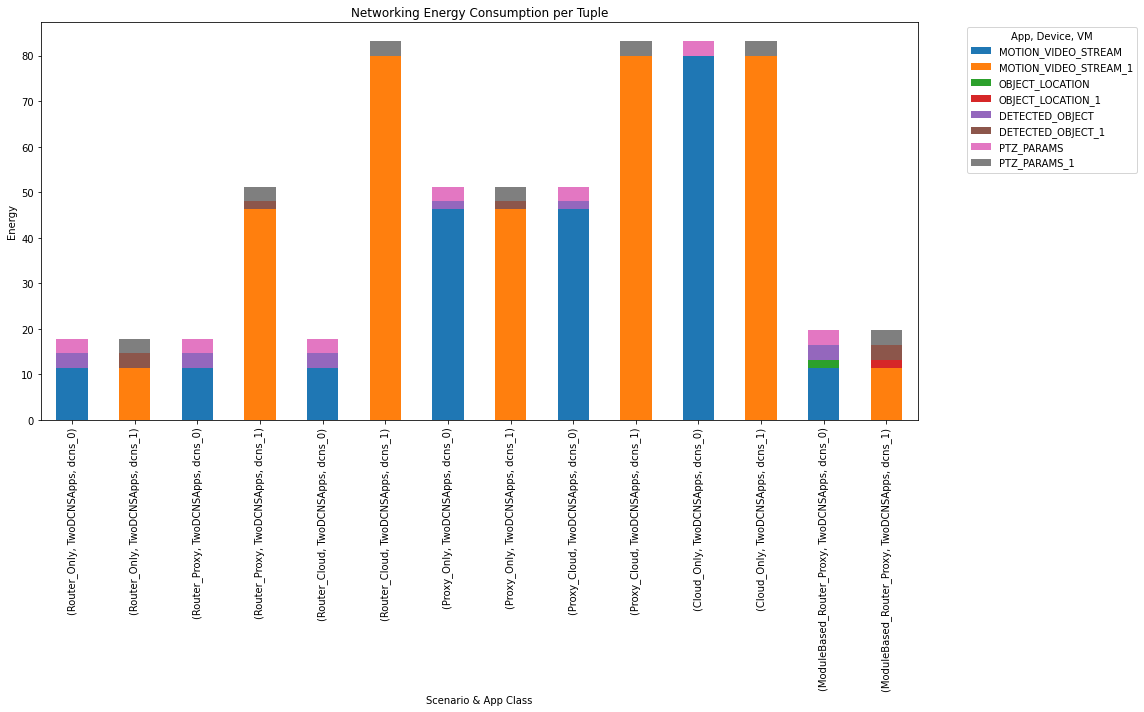

In [17]:
# Comunication energy for twodcns
t=communication_energy_df
#display(t)
t=t.query("app_class in ['TwoDCNSApps']")
#t['energy']=t['energy']/1000

print(t.query("app=='dcns_0'" and "app_class in ['TwoDCNSApps']"))

pivot_df = t.pivot_table(index=['scenario','app_class','app'],columns=['tuple'],values='energy',aggfunc='sum')
pivot_df=pivot_df.reindex(columns=['MOTION_VIDEO_STREAM','MOTION_VIDEO_STREAM_1','OBJECT_LOCATION','OBJECT_LOCATION_1','DETECTED_OBJECT','DETECTED_OBJECT_1','PTZ_PARAMS','PTZ_PARAMS_1'])
display(pivot_df)
pivot_df.to_csv('inobebin.csv')
# Plotting
ax=pivot_df.plot(kind='bar', stacked=True, figsize=(16, 10))
# Customize appearance
ax.set_title("Networking Energy Consumption per Tuple")
ax.set_xlabel("Scenario & App Class")
ax.set_ylabel("Energy")
ax.legend(title='App, Device, VM', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

vm                                                  motion_detector   
app    app_class          scenario                                    
dcns_0 HighResTwoDCNSApps Router_Only                      67.92328  \
                          Router_Proxy                     67.92328   
                          Router_Cloud                     67.92328   
                          Proxy_Only                       67.92328   
                          Proxy_Cloud                      67.92328   
                          Cloud_Only                       67.92328   
                          ModuleBased_Router_Proxy         67.92328   
       LowResTwoDCNSApps  Router_Only                      16.98082   
                          Router_Proxy                     16.98082   
                          Router_Cloud                     16.98082   
                          Proxy_Only                       16.98082   
                          Proxy_Cloud                      16.98082   
                          Cloud_Only                       16.98082   
                          ModuleBased_Router_Proxy         16.98082   
       TwoDCNSApps        Router_Only                      33.96164   
                          Router_Proxy                     33.96164   
                          Router_Cloud                     33.96164   
                          Proxy_Only                       33.96164   
                          Proxy_Cloud                      33.96164   
                          Cloud_Only                       33.96164   
                          ModuleBased_Router_Proxy         33.96164   
dcns_1 HighResTwoDCNSApps Router_Only                       0.00000   
                          Router_Proxy                      0.00000   
                          Router_Cloud                      0.00000   
                          Proxy_Only                        0.00000   
                          Proxy_Cloud                       0.00000   
                          Cloud_Only                        0.00000   
                          ModuleBased_Router_Proxy          0.00000   
       LowResTwoDCNSApps  Router_Only                       0.00000   
                          Router_Proxy                      0.00000   
                          Router_Cloud                      0.00000   
                          Proxy_Only                        0.00000   
                          Proxy_Cloud                       0.00000   
                          Cloud_Only                        0.00000   
                          ModuleBased_Router_Proxy          0.00000   
       TwoDCNSApps        Router_Only                       0.00000   
                          Router_Proxy                      0.00000   
                          Router_Cloud                      0.00000   
                          Proxy_Only                        0.00000   
                          Proxy_Cloud                       0.00000   
                          Cloud_Only                        0.00000   
                          ModuleBased_Router_Proxy          0.00000   

vm                                                  motion_detector_1   
app    app_class          scenario                                      
dcns_0 HighResTwoDCNSApps Router_Only                         0.00000  \
                          Router_Proxy                        0.00000   
                          Router_Cloud                        0.00000   
                          Proxy_Only                          0.00000   
                          Proxy_Cloud                         0.00000   
                          Cloud_Only                          0.00000   
                          ModuleBased_Router_Proxy            0.00000   
       LowResTwoDCNSApps  Router_Only                         0.00000   
                          Router_Proxy                        0.00000   
                          Router_Cloud                        0.00000   

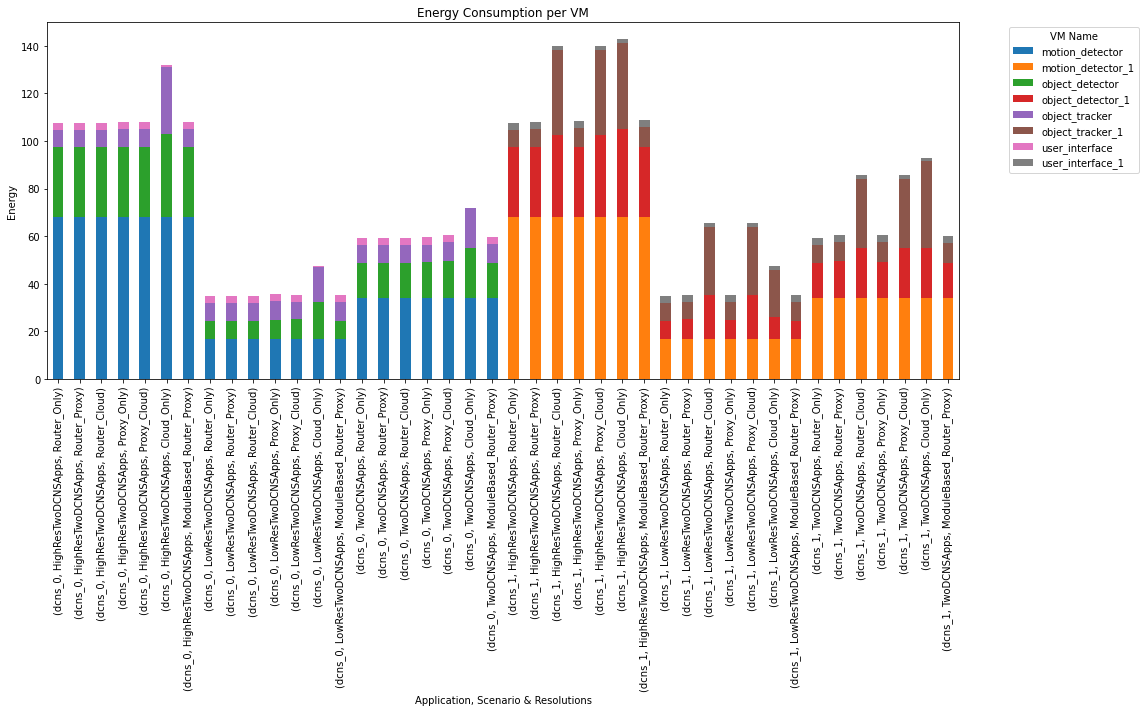

In [18]:

#VM computation Energy for all resolutions(figure edge2024)
t=computation_energy_per_vm_df
#t=t.query("app=='dcns_0'")
#t=t.query("app_class=='TwoDCNSApps'")
#t=t.query("scenario =='Router_Only'")
#t['energy']=t['energy']/1000

#print(t.query("scenario == 'Router_Only'"))

pivot_df = t.pivot_table(index=['app','app_class','scenario'],columns=['vm'],values='energy',aggfunc='sum')
display(pivot_df)
# Plotting
ax=pivot_df.plot(kind='bar', stacked=True, figsize=(16, 10))
# Customize appearance
ax.set_title("Energy Consumption per VM")
ax.set_xlabel("Application, Scenario & Resolutions")
ax.set_ylabel("Energy")
ax.legend(title='VM Name', bbox_to_anchor=(1.05, 1), loc='upper left')


hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
hatch_idx = 0
for patch in ax.patches:
    if hatch_idx >= len(hatch_patterns):
        hatch_idx = 0
    if patch.get_label().startswith('app_1'):
        patch.set_hatch(hatch_patterns[hatch_idx])
        hatch_idx += 1


# Adjust layout
plt.tight_layout()


plt.rcParams['figure.dpi'] = 300  # Adjust DPI for better quality (optional)
# Save the figure as a PDF
#plt.savefig('Report_Saeedeh/Pandas/App_VMs_Computation_Energy_Chart_Fig.pdf', format='pdf', bbox_inches='tight')

# Show plot
plt.show()


tuple                                               MOTION_VIDEO_STREAM   
app    app_class          scenario                                        
dcns_0 HighResTwoDCNSApps Router_Only                         11.476594  \
                          Router_Proxy                        11.476594   
                          Router_Cloud                        11.476594   
                          Proxy_Only                          81.450630   
                          Proxy_Cloud                         81.450630   
                          Cloud_Only                         148.535830   
                          ModuleBased_Router_Proxy            11.476594   
       LowResTwoDCNSApps  Router_Only                         11.269149   
                          Router_Proxy                        11.269149   
                          Router_Cloud                        11.269149   
                          Proxy_Only                          28.762658   
                          Proxy_Cloud                         28.762658   
                          Cloud_Only                          45.533958   
                          ModuleBased_Router_Proxy            11.269149   
       TwoDCNSApps        Router_Only                         11.338297   
                          Router_Proxy                        11.338297   
                          Router_Cloud                        11.338297   
                          Proxy_Only                          46.325315   
                          Proxy_Cloud                         46.325315   
                          Cloud_Only                          79.867915   
                          ModuleBased_Router_Proxy            11.338297   
dcns_1 HighResTwoDCNSApps Router_Only                          0.000000   
                          Router_Proxy                         0.000000   
                          Router_Cloud                         0.000000   
                          Proxy_Only                           0.000000   
                          Proxy_Cloud                          0.000000   
                          Cloud_Only                           0.000000   
                          ModuleBased_Router_Proxy             0.000000   
       LowResTwoDCNSApps  Router_Only                          0.000000   
                          Router_Proxy                         0.000000   
                          Router_Cloud                         0.000000   
                          Proxy_Only                           0.000000   
                          Proxy_Cloud                          0.000000   
                          Cloud_Only                           0.000000   
                          ModuleBased_Router_Proxy             0.000000   
       TwoDCNSApps        Router_Only                          0.000000   
                          Router_Proxy                         0.000000   
                          Router_Cloud                         0.000000   
                          Proxy_Only                           0.000000   
                          Proxy_Cloud                          0.000000   
                          Cloud_Only                           0.000000   
                          ModuleBased_Router_Proxy             0.000000   

tuple                                               MOTION_VIDEO_STREAM_1   
app    app_class          scenario                                          
dcns_0 HighResTwoDCNSApps Router_Only                            0.000000  \
                          Router_Proxy                           0.000000   
                          Router_Cloud                           0.000000   
                          Proxy_Only                             0.000000   
                          Proxy_Cloud                            0.000000   
                          Cloud_Only                             0.000000   
                          ModuleBased_Router_Proxy               0.000000   
      

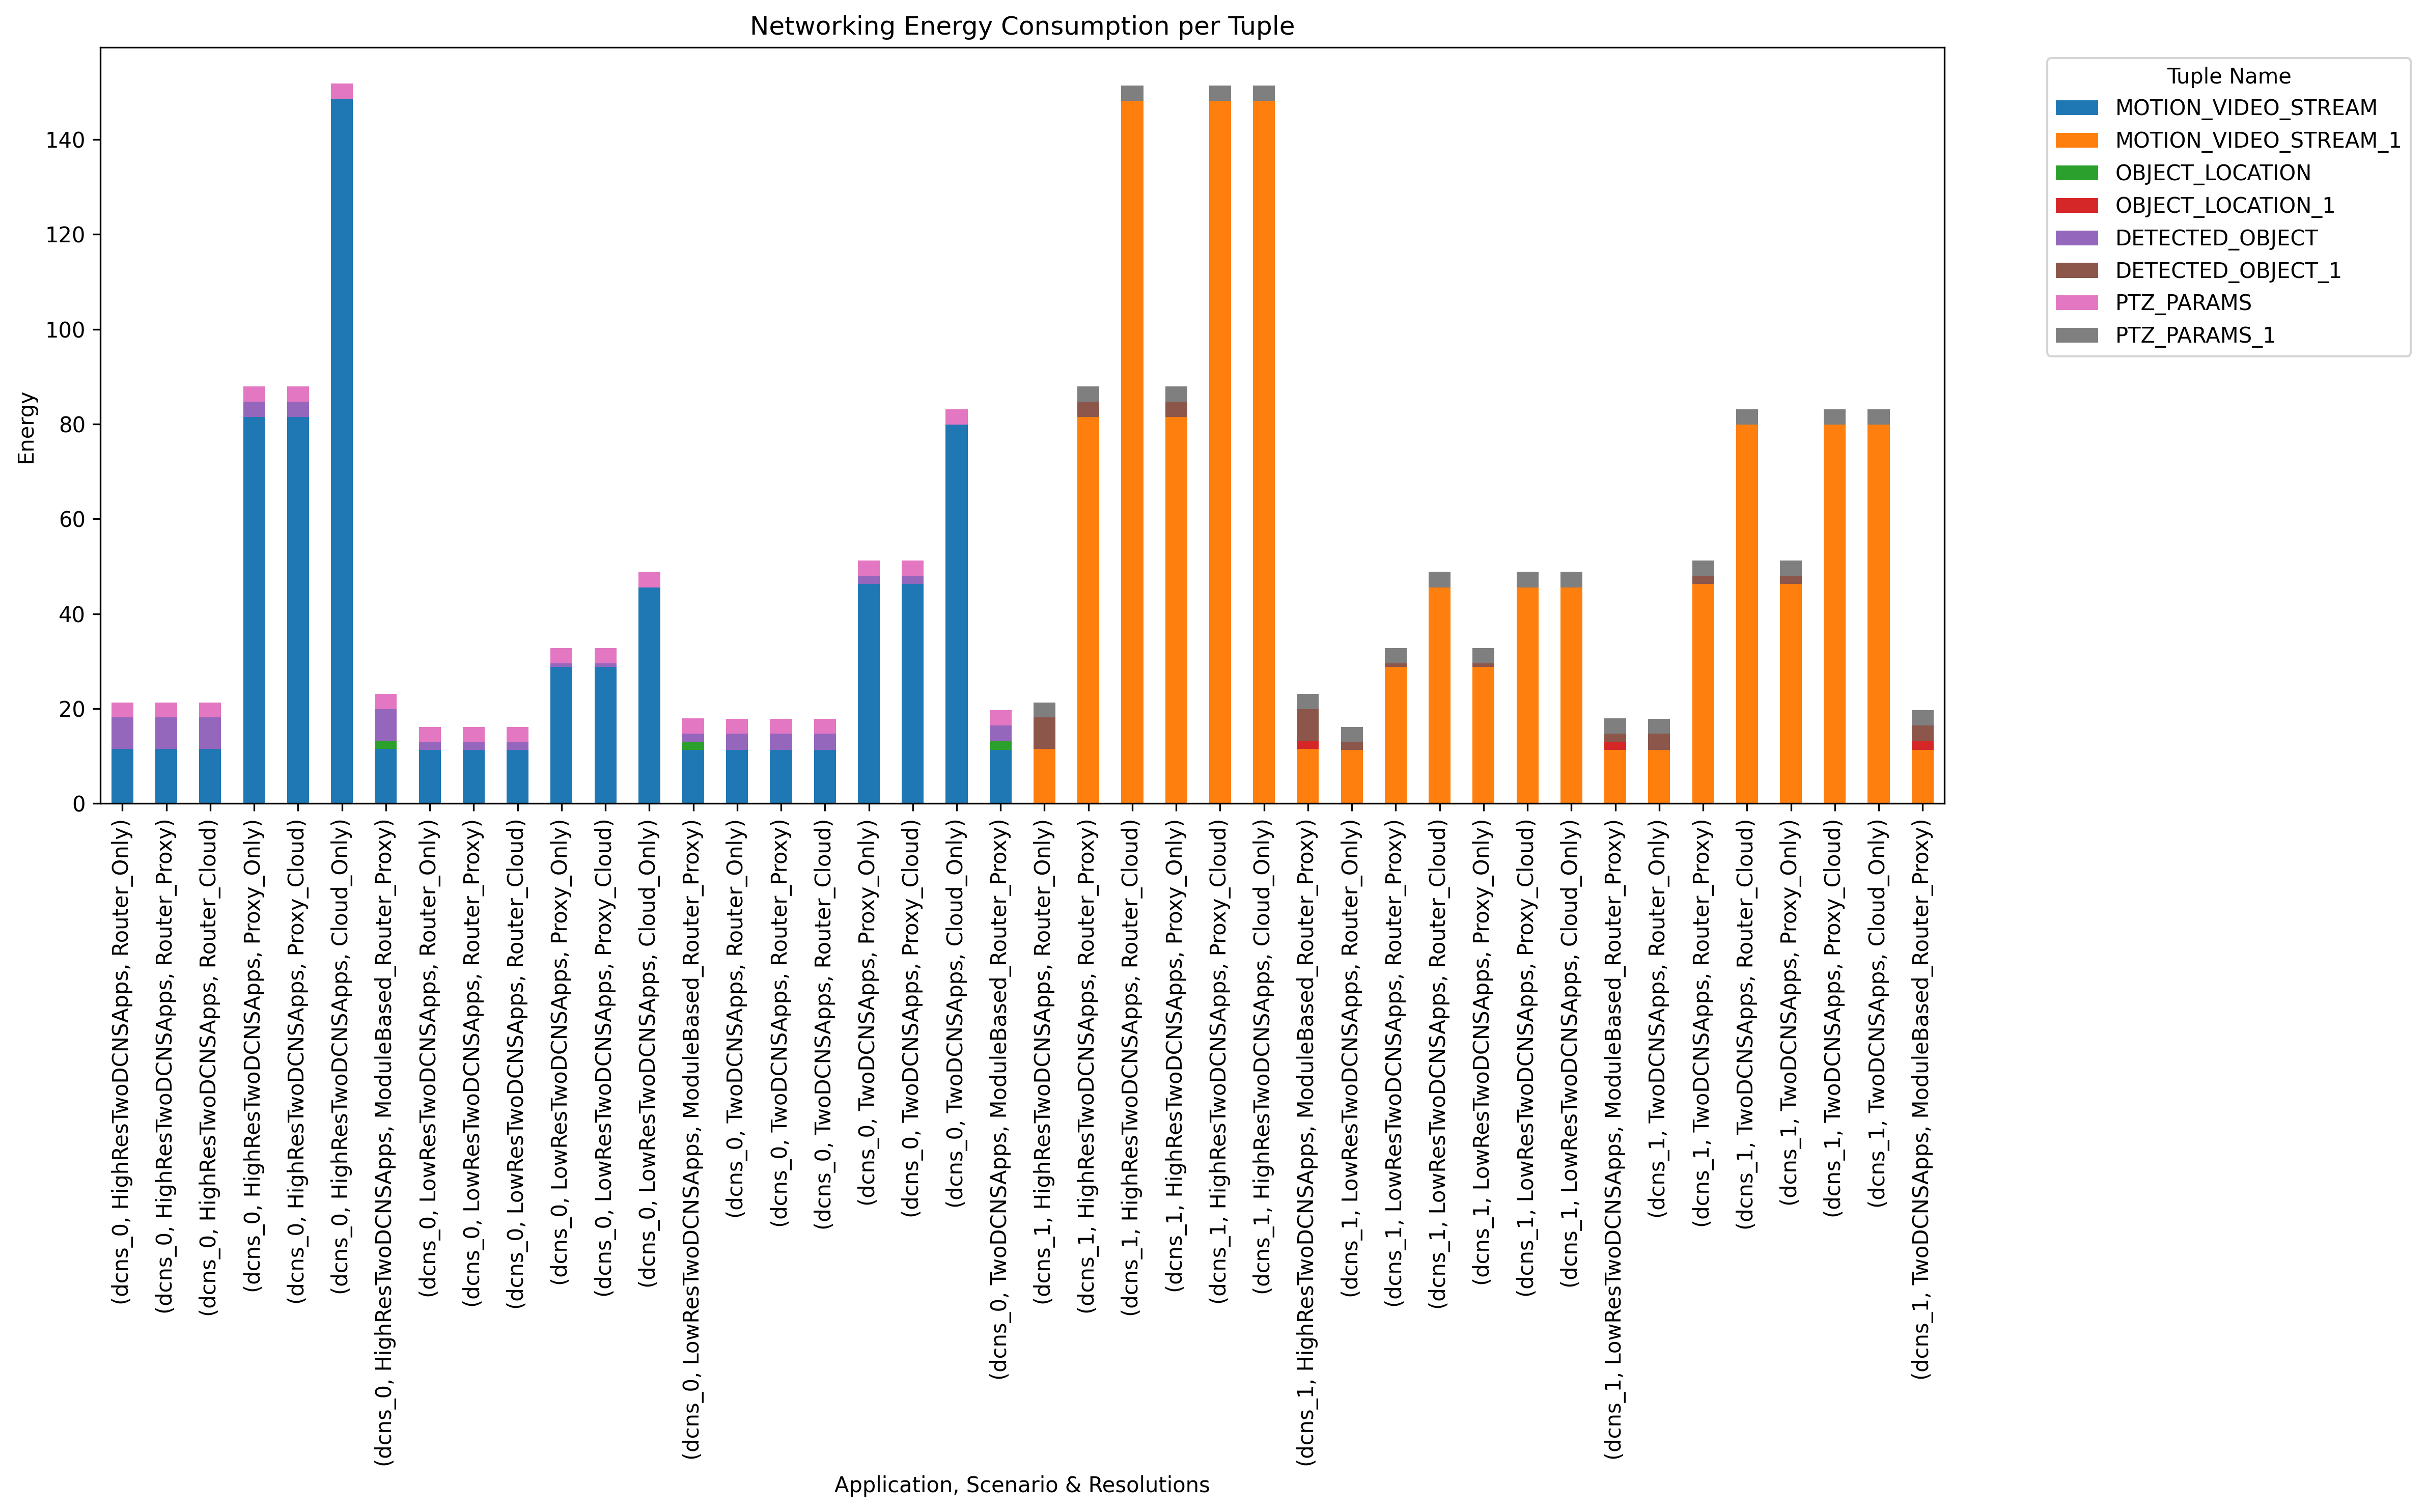

In [19]:
# Comunication energy for twodcns
t=communication_energy_df
#display(t)
#t=t.query("app=='dcns_0'")
#t['energy']=t['energy']/1000

#print(t.query("scenario == 'Cloud_Only' and app=='dcns_1'"))

pivot_df = t.pivot_table(index=['app','app_class','scenario'],columns=['tuple'],values='energy',aggfunc='sum')
pivot_df=pivot_df.reindex(columns=['MOTION_VIDEO_STREAM','MOTION_VIDEO_STREAM_1','OBJECT_LOCATION','OBJECT_LOCATION_1','DETECTED_OBJECT','DETECTED_OBJECT_1','PTZ_PARAMS','PTZ_PARAMS_1'])
display(pivot_df)
pivot_df.to_csv('inobebin.csv')
# Plotting
ax=pivot_df.plot(kind='bar', stacked=True, figsize=(16, 10))
# Customize appearance
ax.set_title("Networking Energy Consumption per Tuple")
ax.set_xlabel("Application, Scenario & Resolutions")
ax.set_ylabel("Energy")
ax.legend(title='Tuple Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()


plt.rcParams['figure.dpi'] = 300  # Adjust DPI for better quality (optional)
# Save the figure as a PDF
plt.savefig('Report_Saeedeh/Pandas/App_Tuples_Communication_Energy_Chart_Fig.pdf', format='pdf', bbox_inches='tight')

# Show plot
plt.show()

app                                                     dcns_0      dcns_1   
app    app_class          scenario                                           
dcns_0 HighResTwoDCNSApps Router_Only                11.064286    0.000000  \
                          Router_Proxy                8.567143    0.000000   
                          Router_Cloud                8.567143    0.000000   
                          Proxy_Only                 15.091101    0.000000   
                          Proxy_Cloud                12.634571    0.000000   
                          Cloud_Only                210.037000    0.000000   
                          ModuleBased_Router_Proxy   15.069765    0.000000   
       LowResTwoDCNSApps  Router_Only                 6.778571    0.000000   
                          Router_Proxy                6.124286    0.000000   
                          Router_Cloud                6.124286    0.000000   
                          Proxy_Only                 10.802429    0.000000   
                          Proxy_Cloud                10.166714    0.000000   
                          Cloud_Only                209.552000    0.000000   
                          ModuleBased_Router_Proxy   10.782561    0.000000   
       TwoDCNSApps        Router_Only                 8.207143    0.000000   
                          Router_Proxy                6.938571    0.000000   
                          Router_Cloud                6.938571    0.000000   
                          Proxy_Only                 12.253338    0.000000   
                          Proxy_Cloud                10.972429    0.000000   
                          Cloud_Only                209.707000    0.000000   
                          ModuleBased_Router_Proxy   12.211632    0.000000   
dcns_1 HighResTwoDCNSApps Router_Only                 0.000000   11.724286   
                          Router_Proxy                0.000000   13.034571   
                          Router_Cloud                0.000000  210.397000   
                          Proxy_Only                  0.000000   16.028754   
                          Proxy_Cloud                 0.000000  210.436000   
                          Cloud_Only                  0.000000  210.412000   
                          ModuleBased_Router_Proxy    0.000000   15.429765   
       LowResTwoDCNSApps  Router_Only                 0.000000    6.838571   
                          Router_Proxy                0.000000   10.266714   
                          Router_Cloud                0.000000  209.627000   
                          Proxy_Only                  0.000000   11.037429   
                          Proxy_Cloud                 0.000000  209.666000   
                          Cloud_Only                  0.000000  209.612000   
                          ModuleBased_Router_Proxy    0.000000   10.842561   
       TwoDCNSApps        Router_Only                 0.000000    8.467143   
                          Router_Proxy                0.000000   11.172429   
                          Router_Cloud                0.000000  209.867000   
                          Proxy_Only                  0.000000   12.668143   
                          Proxy_Cloud                 0.000000  209.906000   
                          Cloud_Only                  0.000000  209.917000   
                          ModuleBased_Router_Proxy    0.000000   12.371632   

app                                                                                            dcns_0   
app    app_class          scenario                                                                      
dcns_0 HighResTwoDCNSApps Router_Only               [motion_detector, object_detector, object_trac...  \
                          Router_Proxy              [motion_detector, object_detector, object_trac...   
                          Router_Cloud              [motion_detector, object_detector, object_trac...   
                          Proxy_Only      

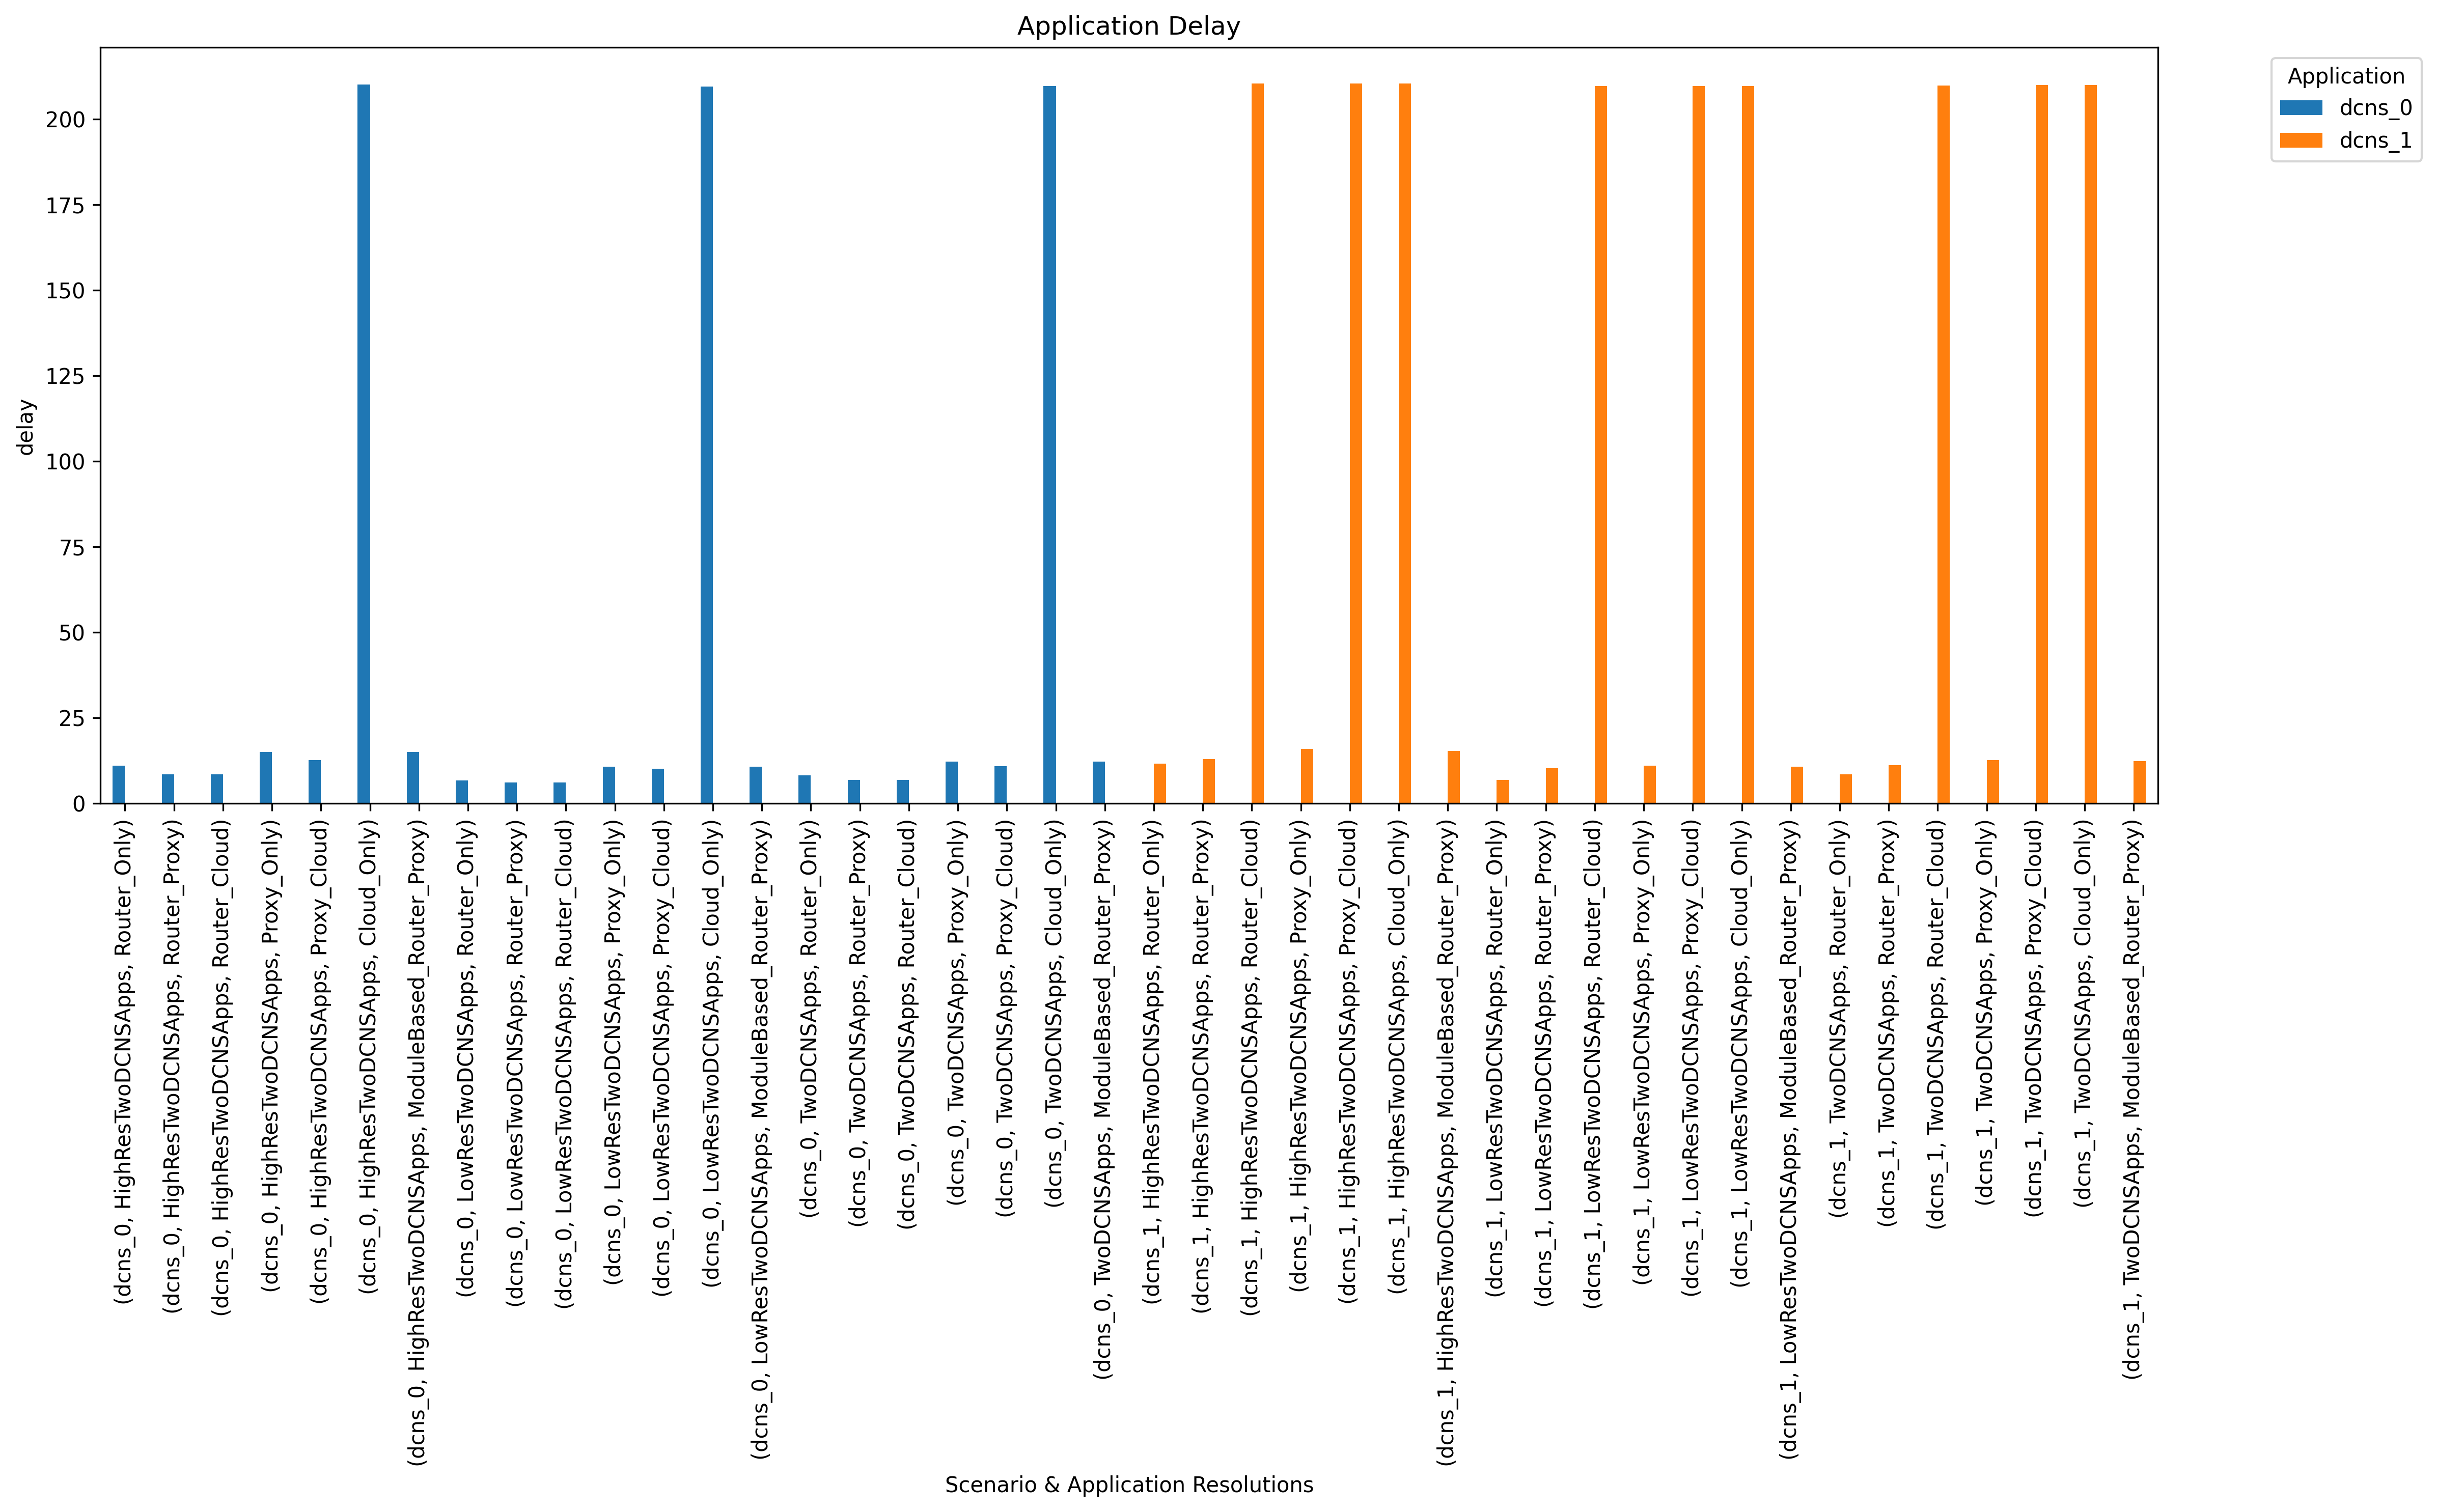

In [20]:

#VM app delays time for all resolutions(figure edge2024)
t=loop_delay_df
#t=t.query("app=='dcns_0'")
#t=t.query("scenario =='Router_Only'")


# Now create the pivot table
#print(t.query("scenario == 'Router_Only'"))

pivot_df = t.pivot_table(index=['app', 'app_class','scenario'],columns=['app'],values='delay',aggfunc='sum')
display(pivot_df)
# Plotting
ax=pivot_df.plot(kind='bar', figsize=(16, 10))
# Customize appearance
ax.set_title("Application Delay")
ax.set_xlabel("Scenario & Application Resolutions")
ax.set_ylabel("delay")
ax.legend(title='Application', bbox_to_anchor=(1.05, 1), loc='upper left')



# Adjust layout
plt.tight_layout()


plt.rcParams['figure.dpi'] = 300  # Adjust DPI for better quality (optional)
# Save the figure as a PDF
plt.savefig('Report_Saeedeh/Pandas/AppDelays_Chart_Fig.pdf', format='pdf', bbox_inches='tight')


# Show plot
plt.show()